**任务时间：题目1-3（11.05-11.10）
题目4、5（11.12-11.17）
题目6（11.19-11.25）**

**互评与筛选时间：题目1-3（11.11）
题目4、5（11.18）
题目6（11.26）**

每周只用提交相应的部分到自己的git，试题实行每周淘汰制

新互评链接：https://yiqixie.com/s/home/fcACT-kZRz10FXWBU2jXDt8VO

# 1、成功读取BTCUSDT:binance的数据，绘出30Min和1H的gap图

'start_date':20180601000000

In [6]:
import warnings

warnings.filterwarnings('ignore')

In [7]:
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
## 加freq参数

start = time()
path = r'./min_data/VnTrader_1Min_Db' #min_data放在同一目录下使用谢谢小伙伴啦！！
props = {'fields': 'open,high,low,close,volume','symbol': \
         'BTCUSDT:binance',
         'freq': '30Min,1H',
         'start_date':20180601000000}

Time_dict = ds.bar_reader(path,props) #读取数据
print(time()-start)

2.7759833335876465


In [8]:
from jaqs_fxdayu.data.hf_dataview import HFDataView

dv30M = HFDataView()
dv1H = HFDataView()

In [9]:
dv30M.create_init_dv(Time_dict['30Min'].dropna().set_index(["trade_date","symbol"]))
dv1H.create_init_dv(Time_dict['1H'].dropna().set_index(["trade_date","symbol"]))

Initialize dataview success.
Initialize dataview success.


In [10]:
Gap1H = dv1H.add_formula('gap', 'close-Delay(open, 1)',add_data=True)
Gap30 = dv30M.add_formula('gap', 'close-Delay(open, 1)',add_data=True)

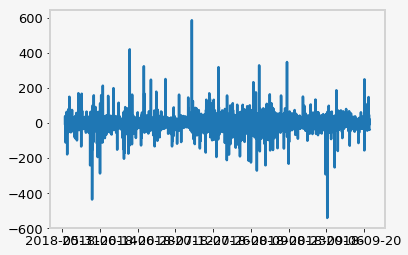

In [11]:
import matplotlib.pyplot as plt

#30min的图
plt.plot(dv30M.get_ts('gap', date_type='datetime')['BTCUSDT:binance'])
plt.show()

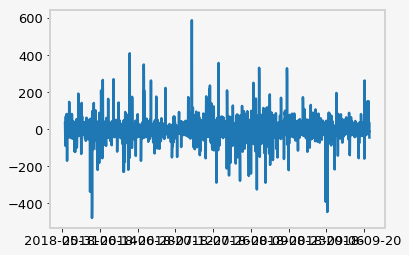

In [12]:
import matplotlib.pyplot as plt

#1H的图
plt.plot(dv1H.get_ts('gap', date_type='datetime')['BTCUSDT:binance'])
plt.show()

# 2、调用alpha101research中的alpha10进行绘图，定义事件，打印绩效

要求：

1、绘出alpha10_dv30M_ma5_ma20、alpha10_dv1H_ma5_ma20的图。

2、定义alpha10的金叉死叉事件，周期为20和55，并打印出long_short的绩效

In [13]:
for dvAdd in [dv30M, dv1H]:
    dvAdd.add_formula('alpha10_C','If(Ts_Min(Delta(close,1),4)>0,Delta(close,1),If((Ts_Max(Delta(close,1),4)<0),Delta(close,1),(-1*Delta(close,1))))',add_data=True)

In [14]:
import matplotlib.pyplot as plt

def Plot_Mean(dv, alpha, chart_name='dv_alpha_ma', ShortPeriod=20, LongPeriod=55, n=0):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,15))
    ax.plot(dv.get_ts('close', date_type='datetime').iloc[:,0].iloc[n:])
    ax.set_title(chart_name,fontsize=24,color='b') 
    ax1.plot(alpha.iloc[n:], alpha=0.1)
    ax1.plot(pd.Series(alpha.rolling(ShortPeriod).mean(), index=alpha.index).iloc[n:])
    ax1.plot(pd.Series(alpha.rolling(LongPeriod).mean(), index=alpha.index).iloc[n:])
#     plt.savefig(chart_name)
    plt.show()

In [15]:
dv_dict = {'alpha10_dv30M':dv30M, 'alpha10_dv1H':dv1H}
alpha10_dict = {n: dv.get_ts('alpha10_C', date_type='datetime') for n, dv in dv_dict.items()}

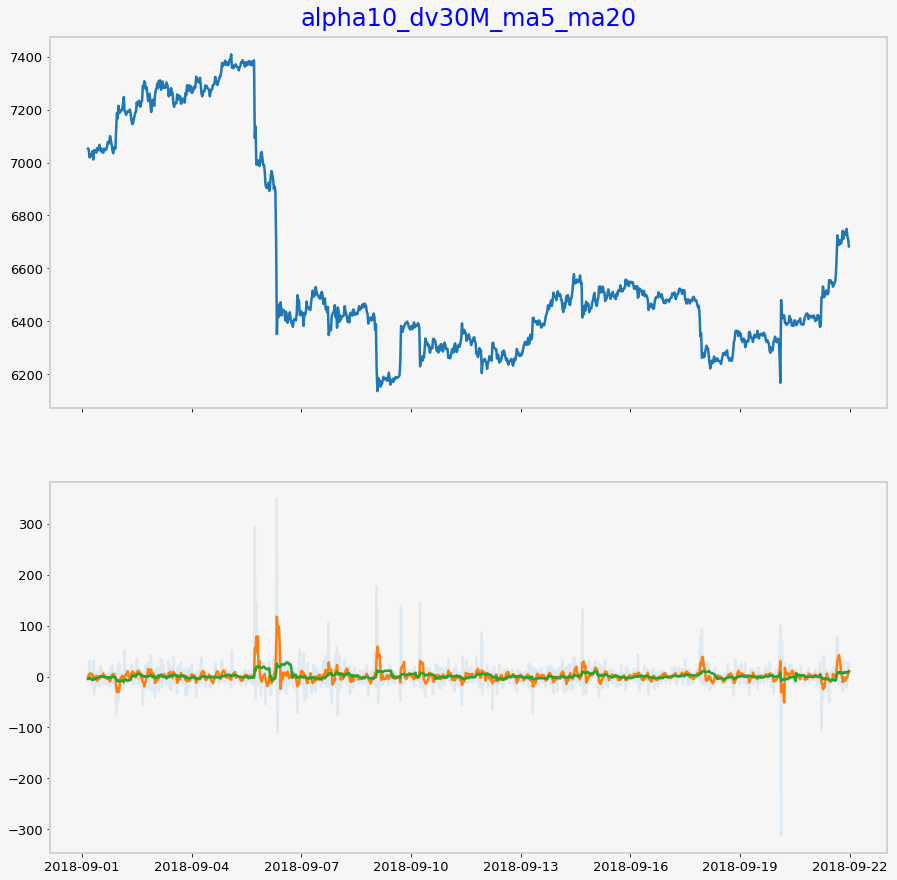

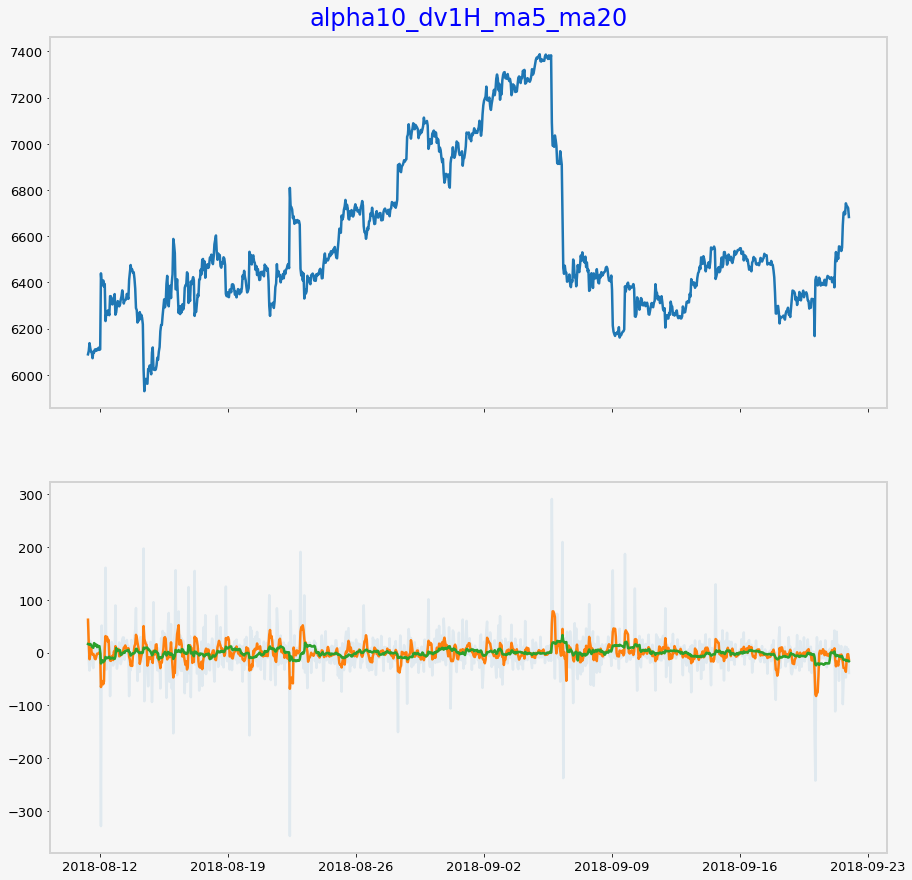

In [16]:
import pandas as pd
#alpha10_dv30M是30分钟线，1H是1小时线，ma30和ma60代表对信号进行均线处理和观察是否与价格存在涨跌关系
for name, alpha in alpha10_dict.items():
    Plot_Mean(globals()[name.split('_')[1]], alpha.iloc[:,0], chart_name=name+'_ma5_ma20',ShortPeriod=5, LongPeriod=20, n=-1000)#橘色短线 绿色长线

In [17]:
# 进场信号
long = dv1H.add_formula("longAlpha10","If((Ts_Mean(alpha10_C,20)>Ts_Mean(alpha10_C,55)) && (Delay(Ts_Mean(alpha10_C,20),1)<=Delay(Ts_Mean(alpha10_C,55),1)),2,0)", add_data=True)
short = dv1H.add_formula("shortAlpha10","If((Ts_Mean(alpha10_C,20)<Ts_Mean(alpha10_C,55)) && (Delay(Ts_Mean(alpha10_C,20),1)>=Delay(Ts_Mean(alpha10_C,55),1)),-2,0)", add_data=True)

# 出场信号
close_long = dv1H.add_formula("closeLongAlpha10","If(shortAlpha10==-2,1,0)", add_data=True)
close_short = dv1H.add_formula("closeShortAlpha10","If(longAlpha10==2,-1,0)", add_data=True)

In [18]:
dv1H.get_ts('longAlpha10').stack()[dv1H.get_ts('longAlpha10').stack()==2].tail()

trade_date      symbol         
20180919050000  BTCUSDT:binance    2.0
20180919080000  BTCUSDT:binance    2.0
20180919110000  BTCUSDT:binance    2.0
20180919160000  BTCUSDT:binance    2.0
20180920230000  BTCUSDT:binance    2.0
dtype: float64

In [19]:
#通过测试报告，看多空信号的绩效，这里是定义报告格式
from jaqs_fxdayu.research import TimingDigger
tdAlpha10 = TimingDigger(output_folder=".", output_format='pdf',signal_name='Alpha010')

def TimingSignal(td, dv,long='long', short='short',closeLong='closeLong', closeShort='closeShort'\
                 , mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称

    #多空信号分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts(long),
        exit_signal=dv.get_ts(closeLong),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts('close'),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts(short),
        exit_signal=dv.get_ts(closeShort),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

In [20]:
TimingSignal(tdAlpha10, dv1H, 'longAlpha10','shortAlpha10','closeLongAlpha10','closeShortAlpha10', 100, 0.05, 0.3)

Nan Data Count (should be zero) : 0;  Percentage of effective data: 6%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 6%


In [21]:
tdAlpha10.create_event_report(sig_type="long_short")

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat                8.290   -9.095   -0.145
p-value               0.000    0.000    0.885
mean                  0.011   -0.011   -0.000
std                   0.016    0.015    0.019
info_ratio            0.677   -0.738   -0.008
skewness              3.664   -1.974    0.697
kurtosis             17.554    2.909    8.470
pct5                  0.001   -0.049   -0.032
pct25                 0.002   -0.012   -0.005
pct50                 0.005   -0.005   -0.000
pct75                 0.012   -0.002    0.005
pct95                 0.041   -0.001    0.027
occurance           151.000  153.000  304.000
win_ratio               NaN      NaN    0.497
win_mean/loss_mean      NaN      NaN    0.984


# 3、打印出Morningstar事件的时间点，绘出Morningstar与成交量的图

数据类型要求：'symbol': 'BTCUSDT:binance',

'freq': '1H','start_date':20180601000000

In [72]:
import warnings

warnings.filterwarnings('ignore')

In [73]:
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
## 加freq参数

start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': \
         'BTCUSDT:binance',
         'freq': '1H',
         'start_date':20180601000000}

Time_dict = ds.bar_reader(path,props) #读取数据
print(time()-start)

2.632962942123413


In [79]:
data1H = Time_dict.set_index('datetime')

In [80]:
from jaqs_fxdayu.data.hf_dataview import HFDataView

dv1H = HFDataView()

In [81]:
dv1H.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))

Initialize dataview success.


In [85]:
def location(df):
    Location = (df.close-df.low.rolling(50).min())/(df.high.rolling(50).max()-df.low.rolling(50).min())*100
    return Location

Location = location(data1H)

In [86]:
import matplotlib.pyplot as plt
import mpl_finance as mpf

def draw_candle(candle, scatterX, scatterY):
    fig, (ax, ax1) = plt.subplots(2,1,sharex=True, figsize=(18,10))
    ax.grid(True)
    mpf.candlestick_ohlc(ax, candle, width=0.3, colorup='r', colordown='g',alpha=1.0)
    ax.scatter(scatterX, scatterY, color='b', s=100, marker='^')
    ax.xaxis_date ()
    ax1.bar(data1H.index, data1H.volume)
    plt.show()

In [120]:
from matplotlib.pylab import date2num

data1H['candleTime'] = list(map(date2num, data1H.index))
candle = data1H.reindex_axis(["candleTime", "open", "high", "low", "close"], 1).values

In [121]:
morningstar = dv1H.add_formula('morningstar', "If((Ta('CDLMORNINGSTAR', 0, open, high, low, close, volume)==100),100,0)", add_data=True)

Field [morningstar] is overwritten.


In [122]:
morningstarVolume = dv1H.get_ts('morningstar', date_type='datetime')

In [126]:
morningstarVolume[morningstarVolume['BTCUSDT:binance']==100]

symbol,BTCUSDT:binance
trade_date,
2018-06-15 22:00:00,100.0
2018-07-12 11:00:00,100.0
2018-07-19 06:00:00,100.0
2018-08-09 17:00:00,100.0
2018-08-31 04:00:00,100.0
2018-09-11 02:00:00,100.0
2018-09-18 01:00:00,100.0
2018-09-19 09:00:00,100.0


In [123]:
morningstarVolumeX = morningstarVolume[morningstarVolume['BTCUSDT:binance']==100].index
morningstarVolumeY = data1H.loc[morningstarVolumeX].low-100

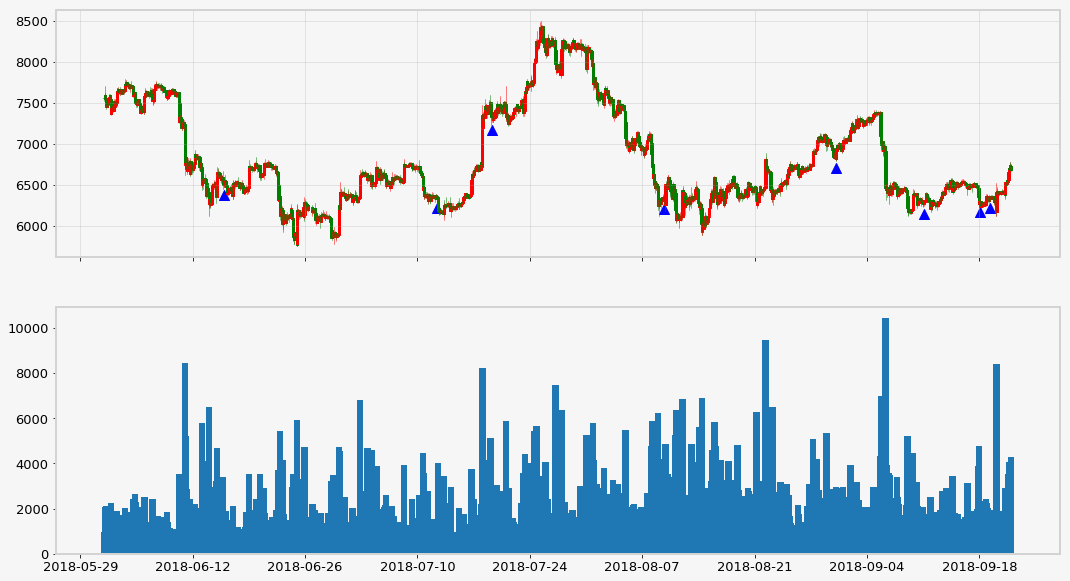

In [124]:
draw_candle(candle, morningstarVolumeX, morningstarVolumeY)

# 4、调用alpha101、alpha191、技术因子、candleresearch或者自己创造衍生因子，要求：任意两个因子，进行画图观察，主要例子看alpha101research和candleresearch，写研究报告（画了什么因子，思考了什么现象，对现象进行描述）


https://github.com/ChannelCMT/formula/wiki

数据类型和周期自定


In [9]:
import warnings

warnings.filterwarnings('ignore')

In [10]:
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
## 加freq参数

start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': 'BTCUSDT:binance', 'freq': '1H',
         'start_date':20180101000000}

Time_dict = ds.bar_reader(path,props)
print(time()-start)

6.485985517501831


In [11]:
from jaqs_fxdayu.data.hf_dataview import HFDataView
dv = HFDataView()

In [12]:
dv.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))

Initialize dataview success.


In [13]:
import matplotlib.pyplot as plt

def plot_chart(close,alpha):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,8))
    ax.plot(close.iloc[-250:])
    ax1.plot(alpha.iloc[-250:])
    # plt.savefig('good')
    plt.show()

In [14]:
#调用Alpha101中Alpha006因子，画图观察
alpha6=dv.add_formula(field_name='alpha6_C',formula='-1*Correlation(open,volume,10)',add_data=True)

In [17]:
alpha6_plot = dv.get_ts('alpha6_C', date_type='datetime')
close = dv.get_ts('close', date_type='datetime')

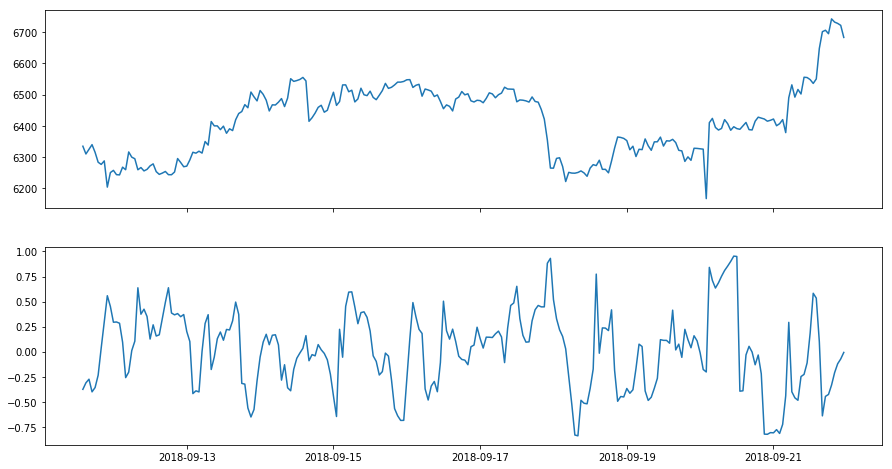

In [18]:
plot_chart(close, alpha6_plot)

In [19]:
#观察发现Alpha006表示的是10日开盘价和成交量的相关系数，相关系数处于振动状态，且与收盘价之间的并不存在明显的比例关系

In [43]:
data1H = Time_dict.set_index('datetime')

In [44]:
from jaqs_fxdayu.data.hf_dataview import HFDataView

dv1H = HFDataView()

In [45]:
dv1H.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))

Initialize dataview success.


In [55]:
def location(df):
    Location = (df.close-df.low.rolling(50).min())/(df.high.rolling(50).max()-df.low.rolling(50).min())*100
    return Location

Location = location(data1H)

In [56]:
import matplotlib.pyplot as plt
import mpl_finance as mpf

def draw_candle(candle, scatterX, scatterY):
    fig, (ax, ax1) = plt.subplots(2,1,sharex=True, figsize=(18,10))
    ax.grid(True)
    mpf.candlestick_ohlc(ax, candle, width=0.3, colorup='r', colordown='g',alpha=1.0)
    ax.scatter(scatterX, scatterY, color='b', s=100, marker='^')
    ax.xaxis_date ()
    ax1.bar(data1H.index, data1H.volume)
    plt.show()

In [57]:
from matplotlib.pylab import date2num

data1H['candleTime'] = list(map(date2num, data1H.index))
candle = data1H.reindex_axis(["candleTime", "open", "high", "low", "close"], 1).values

In [ ]:
#观察蜡烛图的因子, three lines strike

In [62]:
tls = dv1H.add_formula('threelinesstrike', "If((Ta('CDL3LINESTRIKE', 0, open, high, low, close, volume)==100),100,0)", add_data=True)

In [63]:
tls = dv1H.get_ts('threelinesstrike', date_type='datetime')
tlsVolume = dv1H.get_ts('threelinesstrike', date_type='datetime')

In [64]:
tlsVolume[tlsVolume['BTCUSDT:binance']==100]

symbol,BTCUSDT:binance
trade_date,
2018-01-29 19:00:00,100.0
2018-02-13 09:00:00,100.0
2018-04-04 04:00:00,100.0
2018-05-07 08:00:00,100.0
2018-06-20 18:00:00,100.0
2018-07-23 05:00:00,100.0
2018-07-25 14:00:00,100.0
2018-08-01 01:00:00,100.0
2018-08-29 22:00:00,100.0


In [67]:
tlsVolumeX = tlsVolume[tlsVolume['BTCUSDT:binance']==100].index
tlsVolumeY = data1H.loc[tlsVolumeX].low-100

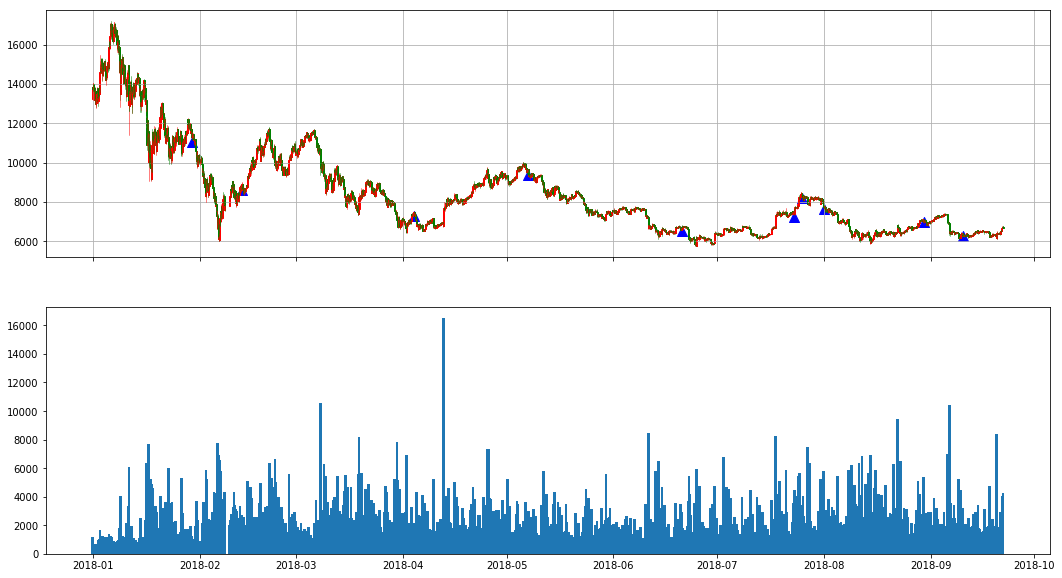

In [68]:
draw_candle(candle, tlsVolumeX, tlsVolumeY)

In [70]:
#通过观察发现蜡烛图，跟成交量之间存在一定的反比关系

# 5、观察两个因子，和价格图有什么联系，如果是蜡烛图，和成交量有什么联系，怎么找到相应的信号，提出自己信号进出场的假设。（分别完成两个因子的信号假设）

信号进出场假设：可以借鉴MastatiscResearch，但不要将思路假设局限在均线上，可以观察大盘上的其他现象来写信号假设，也可以进行同时满足多个因子的信号来设计信号假设等等。

此处需要说出联系、找到的信号、你的信号进出场假设是什么

In [69]:
#联系总结如下：
#观察发现Alpha006表示的是10日开盘价和成交量的相关系数，相关系数处于振动状态，且与收盘价之间的并不存在明显的比例关系
#通过观察发现蜡烛图，跟成交量之间存在一定的反比关系
#进出场假设：均线打分的加总相乘，60分以上做多，40分以下做空

In [71]:
import talib as ta
import numpy as np
import pandas as pd

def calculate(close, timePeriod):
    mas = ta.MA(close.iloc[:,0].values, timePeriod)
    mal = ta.MA(close.iloc[:,0].values, 5*timePeriod)
    df = pd.DataFrame({'long': mal, 'short': mas}, index=close.index).dropna()
    df['direction'] = list(map(lambda s, l: 1 if s > l else 0, df['short'], df['long']))
    return df['direction']

In [72]:
dvClose = dv1H.get_ts('close',date_type='datetime').dropna()
x = np.array(range(1,21,1))
signalDf = pd.DataFrame({t: calculate(dvClose, t) for t in x})

In [73]:
signalDf['signal'] = pd.Series({name: true.sum()*5 for name, true in signalDf.iterrows()}) 

In [74]:
#定义信号
def signalAppend(signalDf):
    signalDf['time'] = signalDf.index
    signalDf["trade_date"] = signalDf['time'].apply(lambda x:int(x.strftime(format="%Y-%m-%d %H:%M:%S").replace("-","").replace(":","").replace(" ","")))
    signalDf["symbol"] = "BTCUSDT:binance"
    signalDf = signalDf.set_index(["trade_date","symbol"])
    signalSe = signalDf.signal.unstack()
    dv1H.append_df(signalSe,'signalSe')
signalAppend(signalDf)

In [75]:
#做多做空信号
long = dv1H.add_formula('long','If((signalSe>=60) && (Delay(signalSe,1)<60), 2, 0)', add_data=True)
short = dv1H.add_formula('short','If((signalSe<=40) && (Delay(signalSe,1)>40), -2, 0)', add_data=True)
closeLong = dv1H.add_formula('closeLong','If(short==-2,1,0)', add_data=True)
closeShort = dv1H.add_formula("closeShort",'If(long==2,-1,0)', add_data=True)

In [76]:
from jaqs_fxdayu.research import TimingDigger

tdMaStatistic = TimingDigger(output_folder=".", output_format='pdf',signal_name='MaStatistic')

def TimingSignal(td, dv, mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称


    #多空分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts("long"),
        exit_signal=dv.get_ts("closeLong"),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts("short"),
        exit_signal=dv.get_ts("closeShort"),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )
TimingSignal(tdMaStatistic, dv1H, 100, 0.15, 0.7)

Nan Data Count (should be zero) : 0;  Percentage of effective data: 1%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 1%


In [77]:
tdMaStatistic.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               4.826 -10.177   1.163
p-value              0.000   0.000   0.248
mean                 0.068  -0.027   0.009
std                  0.079   0.019   0.069
info_ratio           0.853  -1.385   0.125
skewness             1.309  -0.686   2.130
kurtosis             0.565  -0.578   4.644
pct5                 0.002  -0.063  -0.060
pct25                0.008  -0.040  -0.032
pct50                0.037  -0.020  -0.010
pct75                0.090  -0.011   0.011
pct95                0.228  -0.003   0.177
occurance           33.000  55.000  88.000
win_ratio              NaN     NaN   0.375
win_mean/loss_mean     NaN     NaN   2.512


In [78]:
tdMaStatistic.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               6.566 -11.196   0.919
p-value              0.000   0.000   0.360
mean                 0.068  -0.030   0.006
std                  0.060   0.021   0.062
info_ratio           1.143  -1.483   0.096
skewness             0.672  -1.049   1.346
kurtosis            -0.803   0.797   1.316
pct5                 0.003  -0.067  -0.062
pct25                0.019  -0.041  -0.030
pct50                0.050  -0.026  -0.013
pct75                0.109  -0.015   0.022
pct95                0.180  -0.006   0.149
occurance           34.000  58.000  92.000
win_ratio              NaN     NaN   0.370
win_mean/loss_mean     NaN     NaN   2.237


In [79]:
tdMaStatistic.create_event_report(sig_type="long_short")

*****-Summary-*****
Event Analysis
                       win     loss      all
t-stat               7.880  -15.138    1.482
p-value              0.000    0.000    0.140
mean                 0.068   -0.029    0.007
std                  0.070    0.020    0.065
info_ratio           0.970   -1.430    0.111
skewness             1.145   -0.892    1.799
kurtosis             0.467    0.297    3.381
pct5                 0.002   -0.065   -0.061
pct25                0.008   -0.041   -0.031
pct50                0.044   -0.024   -0.011
pct75                0.099   -0.013    0.020
pct95                0.193   -0.004    0.172
occurance           67.000  113.000  180.000
win_ratio              NaN      NaN    0.372
win_mean/loss_mean     NaN      NaN    2.362


In [81]:
#MA20和MA55金叉死叉信号
# 进场信号
long = dv1H.add_formula("long","If((Ts_Mean(close,20)>Ts_Mean(close,55)) && (Delay(Ts_Mean(close,20),1)<=Delay(Ts_Mean(close,55),1)),2,0)", add_data=True)
short = dv1H.add_formula("short","If((Ts_Mean(close,20)<Ts_Mean(close,55)) && (Delay(Ts_Mean(close,20),1)>=Delay(Ts_Mean(close,55),1)),-2,0)", add_data=True)

# 出场信号
close_long = dv1H.add_formula("closeLong","If(short==-2,1,0)", add_data=True)
close_short = dv1H.add_formula("closeShort","If(long==2,-1,0)", add_data=True)

Field [long] is overwritten.
Field [short] is overwritten.
Field [closeLong] is overwritten.
Field [closeShort] is overwritten.


In [82]:
from jaqs_fxdayu.research import TimingDigger

tdMa = TimingDigger(output_folder=".", output_format='pdf',signal_name='Ma')

def TimingSignal(td, dv, long='long', short='short',closeLong='closeLong', closeShort='closeShort'\
                 , mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称

    #多空信号分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts(long),
        exit_signal=dv.get_ts(closeLong),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts('close'),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts(short),
        exit_signal=dv.get_ts(closeShort),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

In [83]:
TimingSignal(tdMa, dv1H, mhp=100, sl=0.05, sp=0.3)#调取数据

Nan Data Count (should be zero) : 0;  Percentage of effective data: 1%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 1%


In [84]:
tdMa.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               3.743 -10.786  -0.379
p-value              0.001   0.000   0.706
mean                 0.062  -0.036  -0.003
std                  0.070   0.020   0.064
info_ratio           0.882  -1.773  -0.051
skewness             1.288   0.126   2.000
kurtosis             0.322  -1.368   4.119
pct5                 0.001  -0.064  -0.058
pct25                0.009  -0.054  -0.051
pct50                0.043  -0.038  -0.019
pct75                0.076  -0.019   0.007
pct95                0.218  -0.005   0.130
occurance           19.000  38.000  57.000
win_ratio              NaN     NaN   0.333
win_mean/loss_mean     NaN     NaN   1.730


In [85]:
tdMa.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               5.868  -7.552   0.931
p-value              0.000   0.000   0.356
mean                 0.071  -0.034   0.008
std                  0.056   0.025   0.066
info_ratio           1.280  -1.335   0.127
skewness             1.276  -0.518   1.164
kurtosis             1.331  -1.016   1.494
pct5                 0.015  -0.075  -0.072
pct25                0.025  -0.054  -0.034
pct50                0.062  -0.021  -0.010
pct75                0.090  -0.013   0.036
pct95                0.175  -0.004   0.122
occurance           22.000  33.000  55.000
win_ratio              NaN     NaN   0.400
win_mean/loss_mean     NaN     NaN   2.113


In [86]:
tdMa.create_event_report(sig_type="long_short")

*****-Summary-*****
Event Analysis
                       win    loss      all
t-stat               6.723 -12.830    0.396
p-value              0.000   0.000    0.693
mean                 0.067  -0.035    0.002
std                  0.063   0.023    0.065
info_ratio           1.063  -1.533    0.038
skewness             1.246  -0.255    1.560
kurtosis             0.690  -1.099    2.591
pct5                 0.004  -0.071   -0.065
pct25                0.022  -0.054   -0.046
pct50                0.050  -0.031   -0.013
pct75                0.089  -0.015    0.023
pct95                0.218  -0.005    0.128
occurance           41.000  71.000  112.000
win_ratio              NaN     NaN    0.366
win_mean/loss_mean     NaN     NaN    1.922


# 6、将你的其中一个假设落实，如果能完成两个更好，但不强求

利用TimingSignal最后输出long、short、long_short这三个绩效表出来
